In [0]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 40000)
pd.set_option('display.max_columns', 600)
pd.set_option('display.width', 3000)

import  matplotlib.pyplot as plt
from wordcloud import WordCloud

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.tokenize import regexp_tokenize 
from string import punctuation
from nltk.stem import WordNetLemmatizer 

from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import re

import string
from string import punctuation

stopwords = stopwords.words('english')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [0]:
cnn = pd.read_csv('cnn.csv')

**data preprocess**

In [0]:
#make all text lowercase
cnn['clean_text'] = cnn['text'].str.lower()
#remove words < 2 chars
cnn['clean_text'] = cnn['clean_text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

#remove links with regex
p=re.compile('(www|http)\S+')
cnn['clean_text'] = cnn['clean_text'].apply(lambda x: re.sub(p,' ',x))
#remove @
cnn['clean_text'] = cnn['clean_text'].apply(lambda x: re.sub('@','',x))

In [0]:
#remove stopwords function
stops =  list(stopwords) + list(punctuation)

def remove_stops(text):
    text_no_stops = []
    for i in text:
        if i not in stops:
            if len(i) == 1:
                pass
            else:
                text_no_stops.append(i)
        else:
            pass
    return text_no_stops

In [0]:
#tokenize
cnn['text_tokenized'] = cnn['clean_text'].apply(lambda x: regexp_tokenize(x,"[\w']+"))

In [0]:
#actually remove stopwords
cnn['text_tokenized'] = cnn['text_tokenized'].apply(lambda x: remove_stops(x))

In [0]:
#lematization function
lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatize_text(text):
    lemmatized = []
    for word in text:
        lemmatized.append(lemmatizer.lemmatize(word))
    return lemmatized

In [0]:
#lemmatize
cnn['text_lemma'] = cnn['text_tokenized'].apply(lemmatize_text)

In [0]:
#create a string from lemmatized words
cnn['lemmatized_string'] = cnn['text_lemma'].apply(lambda x: ' '.join(x))

In [0]:
cnn.tail()

,username,text,date,clean_text,text_tokenized,text_lemma,lemmatized_string
1996,CNNPolitics,"Fact check: Ignoring years of warnings, Presid...",2020-03-20,"fact check: ignoring years warnings, president...","[fact, check, ignoring, years, warnings, presi...","[fact, check, ignoring, year, warning, preside...",fact check ignoring year warning president tru...
1997,CNNPolitics,Fact check: Asked about a coronavirus test sho...,2020-03-19,fact check: asked about coronavirus test short...,"[fact, check, asked, coronavirus, test, shorta...","[fact, check, asked, coronavirus, test, shorta...",fact check asked coronavirus test shortage pre...
1998,CNNPolitics,New York City Mayor Bill de Blasio on a possib...,2020-03-19,new york city mayor bill blasio possible short...,"[new, york, city, mayor, bill, blasio, possibl...","[new, york, city, mayor, bill, blasio, possibl...",new york city mayor bill blasio possible short...
1999,CNNPolitics,Congress needs to take coronavirus more seriou...,2020-03-19,congress needs take coronavirus more seriously...,"[congress, needs, take, coronavirus, seriously...","[congress, need, take, coronavirus, seriously,...",congress need take coronavirus seriously point
2000,CNNPolitics,Coronavirus presents millennials with a genera...,2020-03-19,coronavirus presents millennials with generati...,"[coronavirus, presents, millennials, generatio...","[coronavirus, present, millennials, generation...",coronavirus present millennials generational m...


**create df for tweets about trump**

In [0]:
cnn_trump = pd.DataFrame()

keywords = ['trump']

for k in keywords :
    tmp = cnn[cnn['text'].str.lower().str.contains(k)]
    cnn_trump = cnn_trump.append(tmp)
    
    
    
cnn_trump.sort_values("date", inplace = True,ascending = False)   #sort by date
cnn_trump.drop_duplicates(subset="text",          #drop duplicate titles
                      keep = "first", inplace = True,)
cnn_trump = cnn_trump.reset_index(drop=True) #reset index
print("Trump related tweets: ",cnn_trump.shape[0])


Trump related tweets:  750


In [0]:
cnn_trump['label'] = 'trump'

**create df for tweets about sanders** *italicized text*

In [0]:
cnn_sanders = pd.DataFrame()

keywords = ['bernie','sanders']

for k in keywords :
    tmp = cnn[cnn['text'].str.lower().str.contains(k)]
    cnn_sanders = cnn_sanders.append(tmp)
    
    
    
cnn_sanders.sort_values("date", inplace = True,ascending = False)   #sort by date
cnn_sanders.drop_duplicates(subset="text",          #drop duplicate titles
                      keep = "first", inplace = True,)
cnn_sanders = cnn_sanders.reset_index(drop=True) #reset index
print("Sanders related tweets: ",cnn_sanders.shape[0])


Sanders related tweets:  29


In [0]:
cnn_sanders['label'] = 'sanders'

In [0]:
index = cnn_trump.index
tr_rows = len(index)

In [0]:
index = cnn_sanders.index
san_rows = len(index)

**plot how many mentions each candidate gets**

In [0]:
mentions = [tr_rows,san_rows]

In [0]:
candidates =['Trump','Sanders']

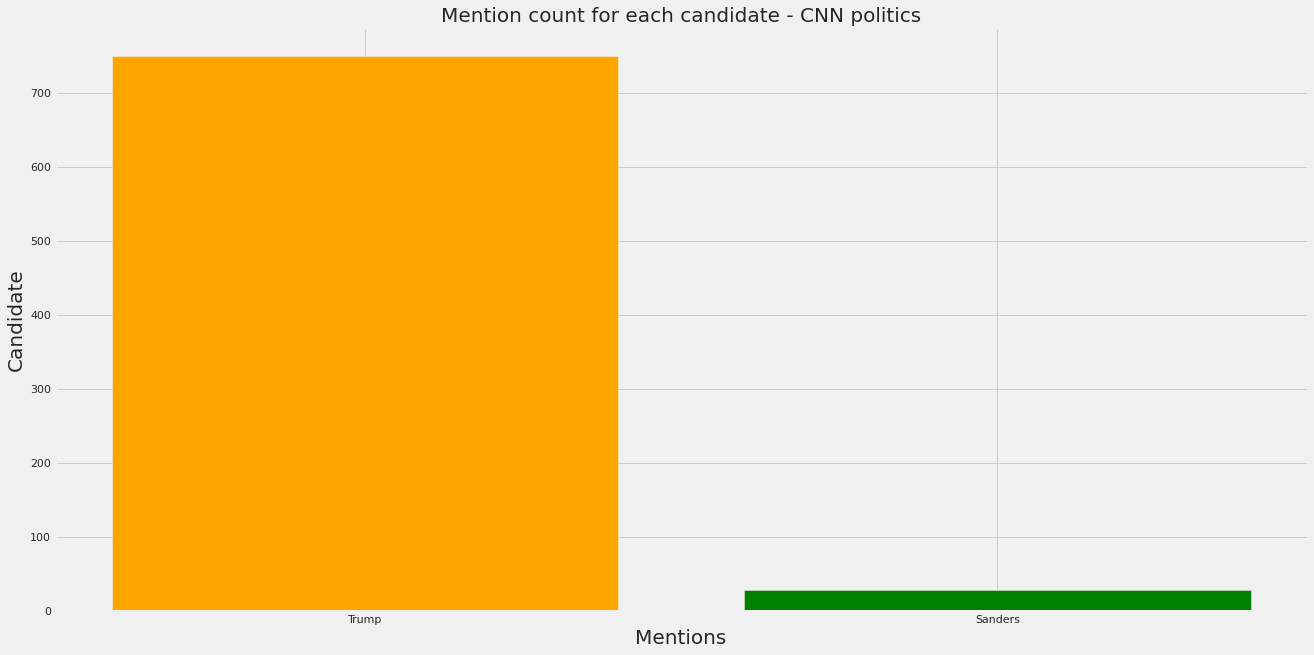

In [0]:
plt.figure(figsize=(20,10))
fig=plt.bar(candidates,mentions,color=('orange','green'))
plt.title("Mention count for each candidate - CNN politics",fontsize=20)
plt.xlabel("Mentions",fontsize=20)
plt.ylabel('Candidate',fontsize=20)
plt.show()

**sentiment analysis**

In [0]:
from textblob import TextBlob

In [0]:
def analyze_sentiment(text):
    analysis = TextBlob(text)
    #return  analysis.sentiment.polarity
    
    if analysis.sentiment.polarity > 0:
        return 'positive'
    elif analysis.sentiment.polarity == 0:
        return 'neutral'
    else:
        return 'negative'

In [0]:
cnn_trump['sentiment'] = np.array([ analyze_sentiment(tweet) for tweet in cnn_trump['lemmatized_string'] ])

In [0]:
cnn_sanders['sentiment'] = np.array([ analyze_sentiment(tweet) for tweet in cnn_sanders['lemmatized_string'] ])

In [0]:
import seaborn as sns
sns.set(rc={'figure.figsize':(13,9)})
plt.style.use('fivethirtyeight')

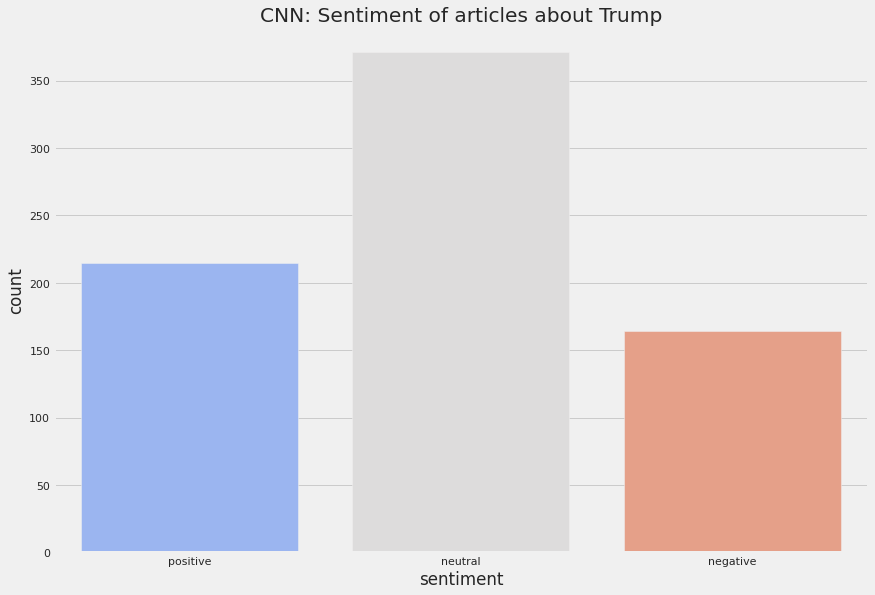

In [0]:
ax = sns.countplot(x= 'sentiment', data=cnn_trump,palette='coolwarm').set_title('CNN: Sentiment of articles about Trump')
plt.show()

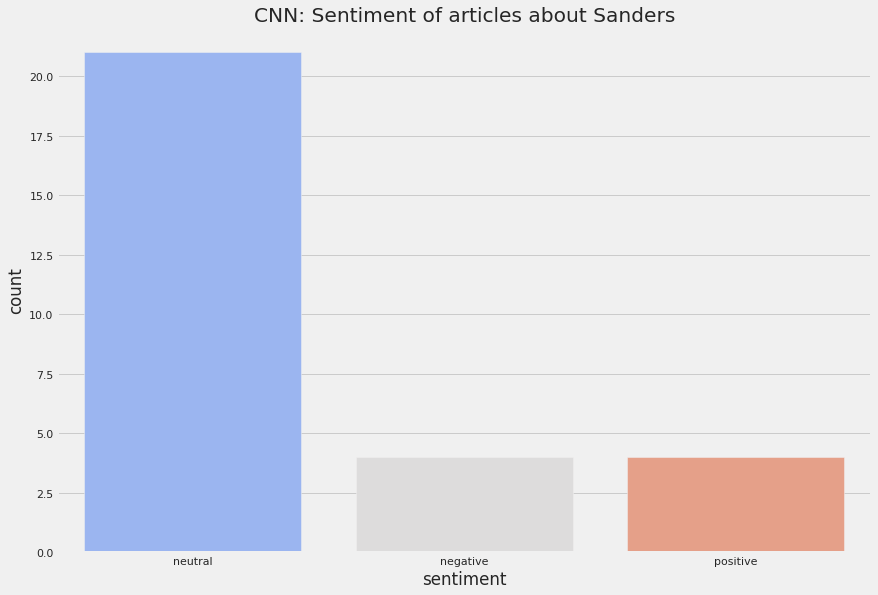

In [0]:
ax = sns.countplot(x= 'sentiment', data=cnn_sanders,palette='coolwarm').set_title('CNN: Sentiment of articles about Sanders')
plt.show()

###Analysis of articles recovered from rss feeds

articles recovered from: nytimes, bbc, rt, aljazzera, 

In [0]:
rss = pd.read_csv("rss_feed_english.csv")

In [0]:
rss.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7366 entries, 0 to 7365
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    7366 non-null   object
 1   date     7366 non-null   object
 2   summary  7366 non-null   object
 3   link     7366 non-null   object
dtypes: object(4)
memory usage: 230.3+ KB


In [0]:
rss.drop_duplicates(subset="link",keep = "first", inplace = True)


In [0]:
rss.title = rss.title.astype('str')
rss.summary = rss.summary.astype('str')

In [0]:
rss['text'] = rss.title + rss.summary

**the usual preproccessing**

In [0]:
#make all text lowercase
rss['clean_text'] = rss['text'].str.lower()

In [0]:
#remove words < 2 chars
rss['clean_text'] = rss['clean_text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

#remove links with regex
p=re.compile('(www|http)\S+')
rss['clean_text'] = rss['clean_text'].apply(lambda x: re.sub(p,' ',x))
#remove @
rss['clean_text'] = rss['clean_text'].apply(lambda x: re.sub('@','',x))

In [0]:
#tokenize
rss['text_tokenized'] = rss['clean_text'].apply(lambda x: regexp_tokenize(x,"[\w']+"))

In [0]:
#actually remove stopwords
rss['text_tokenized'] = rss['text_tokenized'].apply(lambda x: remove_stops(x))

In [0]:
#lemmatize
rss['text_lemma'] = rss['text_tokenized'].apply(lemmatize_text)

In [0]:
#create a string from lemmatized words
rss['lemmatized_string'] = rss['text_lemma'].apply(lambda x: ' '.join(x))

In [0]:
rss_trump = pd.DataFrame()

keywords = ['trump']

for k in keywords :
    tmp = rss[rss['text'].str.lower().str.contains(k)]
    rss_trump = rss_trump.append(tmp)
    
    
    
rss_trump.sort_values("date", inplace = True,ascending = False)   #sort by date
rss_trump = rss_trump.reset_index(drop=True) #reset index
print("Trump related articles: ",rss_trump.shape[0])


Trump related articles:  106


In [0]:
rss_sanders = pd.DataFrame()

keywords = ['sanders']

for k in keywords :
    tmp = rss[rss['text'].str.lower().str.contains(k)]
    rss_sanders = rss_sanders.append(tmp)
    
    
    
rss_sanders.sort_values("date", inplace = True,ascending = False)   #sort by date
rss_sanders = rss_sanders.reset_index(drop=True) #reset index
print("Sanders related articles: ",rss_sanders.shape[0])


Sanders related articles:  19


In [0]:
rss.tail()

,title,date,summary,link,text,clean_text,text_tokenized,text_lemma,lemmatized_string
7318,Researchers unearth deep-sea bacteria with met...,2020-4-4,A peculiar form of bacteria discovered on the...,https://www.rt.com/news/484973-deep-sea-bacter...,Researchers unearth deep-sea bacteria with met...,researchers unearth deep-sea bacteria with met...,"[researchers, unearth, deep, sea, bacteria, me...","[researcher, unearth, deep, sea, bacteria, met...",researcher unearth deep sea bacteria metabolis...
7319,LISTEN: China pays tribute to Covid-19 victims...,2020-4-4,China has held a nationwide day of mourning f...,https://www.rt.com/news/484953-china-coronavir...,LISTEN: China pays tribute to Covid-19 victims...,listen: china pays tribute covid-19 victims wi...,"[listen, china, pays, tribute, covid, 19, vict...","[listen, china, pay, tribute, covid, 19, victi...",listen china pay tribute covid 19 victim minut...
7320,"Two killed, several injured in stabbing attack...",2020-4-4,At least two people have been killed and mult...,https://www.rt.com/news/484961-stabbing-attack...,"Two killed, several injured in stabbing attack...","two killed, several injured stabbing attack fr...","[two, killed, several, injured, stabbing, atta...","[two, killed, several, injured, stabbing, atta...",two killed several injured stabbing attack fre...
7321,‘Govt sends us NAKED against Covid-19’: RT spe...,2020-4-4,French caregivers battling Covid-19 are appal...,https://www.rt.com/news/484948-french-nurses-n...,‘Govt sends us NAKED against Covid-19’: RT spe...,‘govt sends naked against covid-19’: speaks fr...,"[govt, sends, naked, covid, 19, speaks, french...","[govt, sends, naked, covid, 19, speaks, french...",govt sends naked covid 19 speaks french nurse ...
7365,Migrant protests take place in Sweden’s Gothen...,2020-4-1,Sweden has banned gatherings of more than 50 ...,https://www.rt.com/news/484700-sweden-migrant-...,Migrant protests take place in Sweden’s Gothen...,migrant protests take place sweden’s gothenbur...,"[migrant, protests, take, place, sweden, gothe...","[migrant, protest, take, place, sweden, gothen...",migrant protest take place sweden gothenburg d...


In [0]:
rss_biden = pd.DataFrame()

keywords = ['biden']

for k in keywords :
    tmp = rss[rss['text'].str.lower().str.contains(k)]
    rss_biden = rss_biden.append(tmp)
    
    
    
rss_biden.sort_values("date", inplace = True,ascending = False)   #sort by date
rss_biden = rss_biden.reset_index(drop=True) #reset index
print("Biden related articles: ",rss_biden.shape[0])


Biden related articles:  26


In [0]:
index = rss_trump.index
tr_rows = len(index)
index = rss_sanders.index
san_rows = len(index)
index = rss_biden.index
bid_rows = len(index)

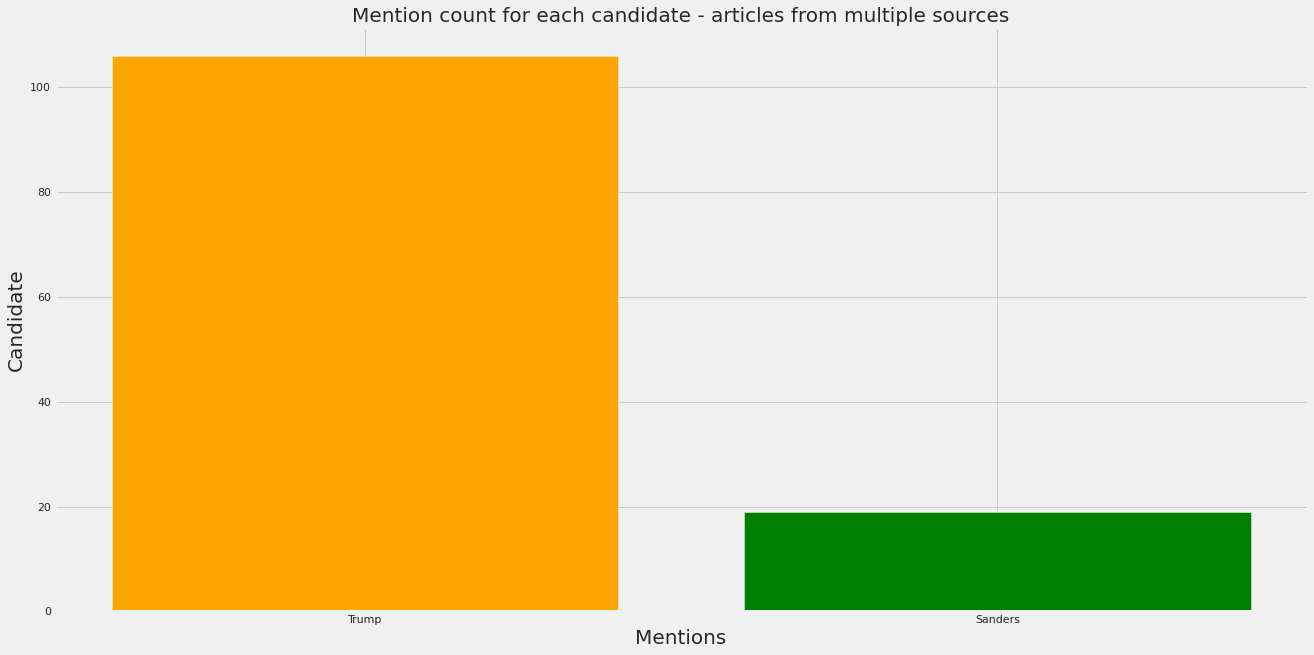

In [0]:
mentions = [tr_rows,san_rows]
candidates = ['Trump','Sanders']

plt.figure(figsize=(20,10))
fig=plt.bar(candidates,mentions,color=('orange','green'))
plt.title("Mention count for each candidate - articles from multiple sources",fontsize=20)
plt.xlabel("Mentions",fontsize=20)
plt.ylabel('Candidate',fontsize=20)
plt.show()

In [0]:
rss_trump['sentiment'] = np.array([ analyze_sentiment(tweet) for tweet in rss_trump['lemmatized_string'] ])

In [0]:
rss_sanders['sentiment'] = np.array([ analyze_sentiment(tweet) for tweet in rss_sanders['lemmatized_string'] ])

In [0]:
rss_biden['sentiment'] = np.array([ analyze_sentiment(tweet) for tweet in rss_biden['lemmatized_string'] ])

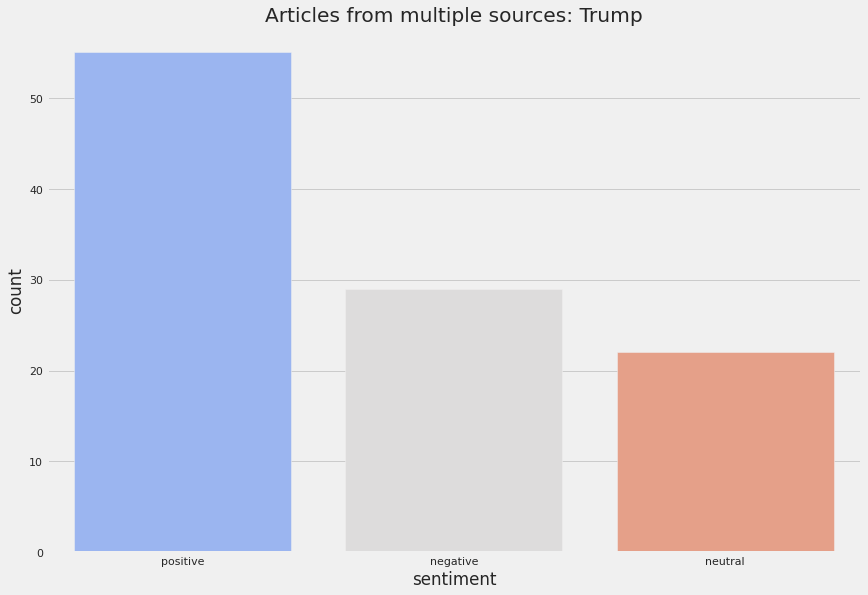

In [0]:
ax = sns.countplot(x= 'sentiment', data=rss_trump,palette='coolwarm').set_title('Articles from multiple sources: Trump')
plt.show()

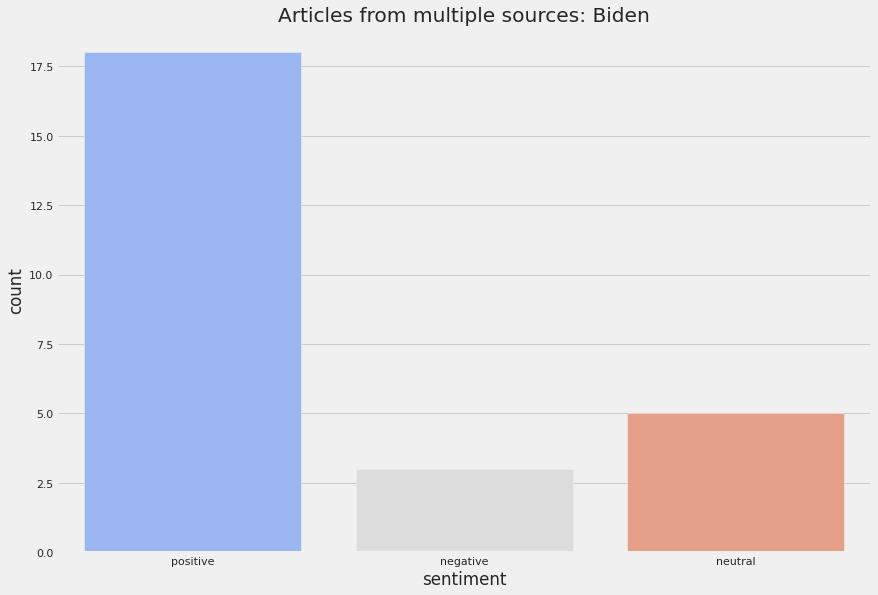

In [0]:
ax = sns.countplot(x= 'sentiment', data=rss_biden,palette='coolwarm').set_title('Articles from multiple sources: Biden')
plt.show()

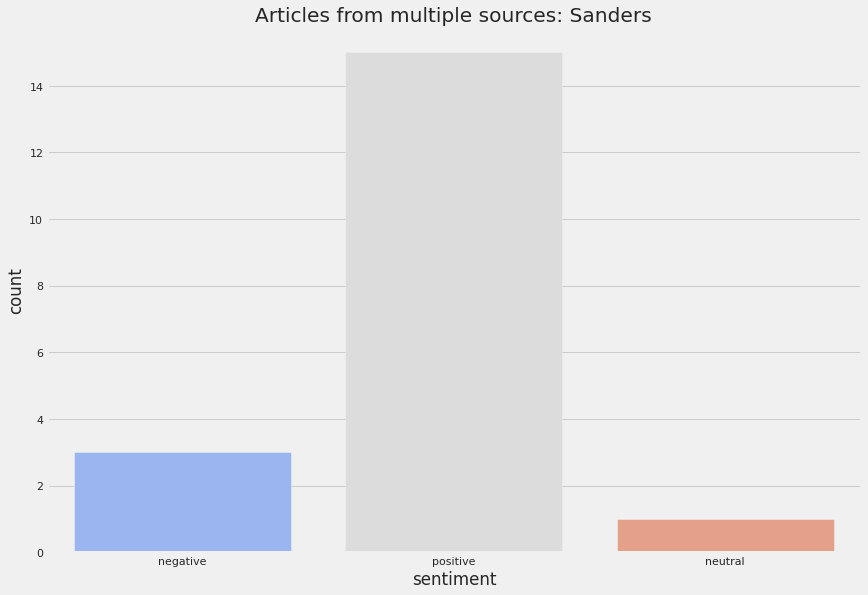

In [0]:
ax = sns.countplot(x= 'sentiment', data=rss_sanders,palette='coolwarm').set_title('Articles from multiple sources: Sanders')
plt.show()

**clustering**

In [0]:
rss_trump.head()

,title,date,summary,link,text,clean_text,text_tokenized,text_lemma,lemmatized_string,sentiment
0,‘What do you have to lose?’ Trump touts anti-m...,2020-4-5,Praising the anti-malaria drug hydroxychloroq...,https://www.rt.com/news/484998-trump-modi-hydr...,‘What do you have to lose?’ Trump touts anti-m...,‘what you have lose?’ trump touts anti-malaria...,"[lose, trump, touts, anti, malaria, drug, covi...","[lose, trump, tout, anti, malaria, drug, covid...",lose trump tout anti malaria drug covid 19 cur...,positive
1,Coronavirus live news: Trump tells Americans t...,2020-4-5,"Global deaths approach 65,000; Spain infection...",https://www.theguardian.com/world/live/2020/ap...,Coronavirus live news: Trump tells Americans t...,coronavirus live news: trump tells americans e...,"[coronavirus, live, news, trump, tells, americ...","[coronavirus, live, news, trump, tell, america...",coronavirus live news trump tell american expe...,positive
2,Front Row at the Trump Show review: Jonathan K...,2020-4-5,The ABC News White House correspondent first m...,https://www.theguardian.com/us-news/2020/apr/0...,Front Row at the Trump Show review: Jonathan K...,front row the trump show review: jonathan karl...,"[front, row, trump, show, review, jonathan, ka...","[front, row, trump, show, review, jonathan, ka...",front row trump show review jonathan karl's pr...,positive
3,'A lot of death' ahead in US fight against COV...,2020-4-5,"Trump issues stark warning, pledges to deploy ...",https://www.aljazeera.com/news/2020/04/trump-w...,'A lot of death' ahead in US fight against COV...,lot death' ahead fight against covid-19: live ...,"[lot, death', ahead, fight, covid, 19, live, u...","[lot, death', ahead, fight, covid, 19, live, u...",lot death' ahead fight covid 19 live updatestr...,negative
4,Coronavirus: Trump predicts ‘a lot of death’ a...,2020-4-5,"The US president predicts ""a lot of death"" but...",https://www.bbc.co.uk/news/world-us-canada-521...,Coronavirus: Trump predicts ‘a lot of death’ a...,coronavirus: trump predicts lot death’ cases p...,"[coronavirus, trump, predicts, lot, death, cas...","[coronavirus, trump, predicts, lot, death, cas...",coronavirus trump predicts lot death case pas ...,positive


In [0]:
# tfidf vectorizer of scikit learn

vectorizer = TfidfVectorizer(stop_words=stopwords,use_idf = True, ngram_range=(1,2))
#vectorize lemmatized tweets
X = vectorizer.fit_transform(rss_sanders['lemmatized_string'])
terms = vectorizer.get_feature_names()

In [0]:
from sklearn.cluster import KMeans

In [0]:
#K-means clustering
num_clusters = 2
km = KMeans(n_clusters=num_clusters,init='k-means++')
labels = km.fit_predict(X)

In [0]:
print("K-means clustering: \n")
asc_order_centroids = km.cluster_centers_.argsort()#[:, ::-1]
order_centroids = asc_order_centroids[:,::-1]
terms = vectorizer.get_feature_names()
for i in range(num_clusters):
    print ("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print (' %s' % terms[ind])
    print('\n')


K-means clustering: 

Cluster 0:
 sander
 biden
 win
 democratic
 key
 tuesday
 state
 bernie
 michigan
 primary


Cluster 1:
 coronavirus
 rally
 campaign
 sanders
 biden bernie
 biden
 sander
 election
 outbreak
 coronavirus outbreak




In [0]:
rss_trump['cluster'] = labels